In [114]:
import numpy as np
import pickle
import os
import seaborn as sns
colors = sns.color_palette("colorblind")
import matplotlib.pyplot as plt
plt.style.use('~/latex-cm.mplstyle')

import sys
sys.path.append('/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy')
from scripts.config import MAPS_DIR, PARTICLE_DICT, TPC_AVG_CROSS_SECTION

particle_names = {k: v[0] for k, v in PARTICLE_DICT.items()}

In [103]:
# load photon yield pickle
yield_path = os.path.join(MAPS_DIR, 'pkl', 'photon_yield.pkl')
with open(yield_path, 'rb') as f:
    photon_yield = pickle.load(f)
print(f'Loaded photon_yield.pkl: {list(photon_yield.keys())}')

# load weights
weights_path = os.path.join(MAPS_DIR, 'pkl', 'weights.pkl')
with open(weights_path, 'rb') as f:
    weights = pickle.load(f)
print(f'Loaded weights.pkl: {list(weights.keys())}')

# preview weights
for p, w in weights.items():
    print(f"  {p}: S={w['S']:.3e} cm^-2 s^-1 sr^-1, w={w['w']:.3e} cm^-2 s^-1, T={w['T']:.3e} s")

Loaded photon_yield.pkl: ['neutro', 'proton', 'he---4', 'muplus', 'mumins', 'electr', 'positr', 'photon']
Loaded weights.pkl: ['neutro', 'proton', 'he---4', 'muplus', 'mumins', 'electr', 'positr', 'photon']
  neutro: S=6.126e+02 cm^-2 s^-1 sr^-1, w=4.385e-02 cm^-2 s^-1, T=1.596e+04 s
  proton: S=1.023e+02 cm^-2 s^-1 sr^-1, w=7.326e-03 cm^-2 s^-1, T=9.554e+04 s
  he---4: S=6.570e+00 cm^-2 s^-1 sr^-1, w=4.703e-04 cm^-2 s^-1, T=1.488e+06 s
  muplus: S=1.489e+01 cm^-2 s^-1 sr^-1, w=1.066e-03 cm^-2 s^-1, T=6.567e+05 s
  mumins: S=1.346e+01 cm^-2 s^-1 sr^-1, w=9.633e-04 cm^-2 s^-1, T=7.267e+05 s
  electr: S=2.698e+02 cm^-2 s^-1 sr^-1, w=1.931e-02 cm^-2 s^-1, T=3.624e+04 s
  positr: S=1.569e+02 cm^-2 s^-1 sr^-1, w=1.123e-02 cm^-2 s^-1, T=6.231e+04 s
  photon: S=6.904e+03 cm^-2 s^-1 sr^-1, w=4.943e-01 cm^-2 s^-1, T=1.416e+03 s


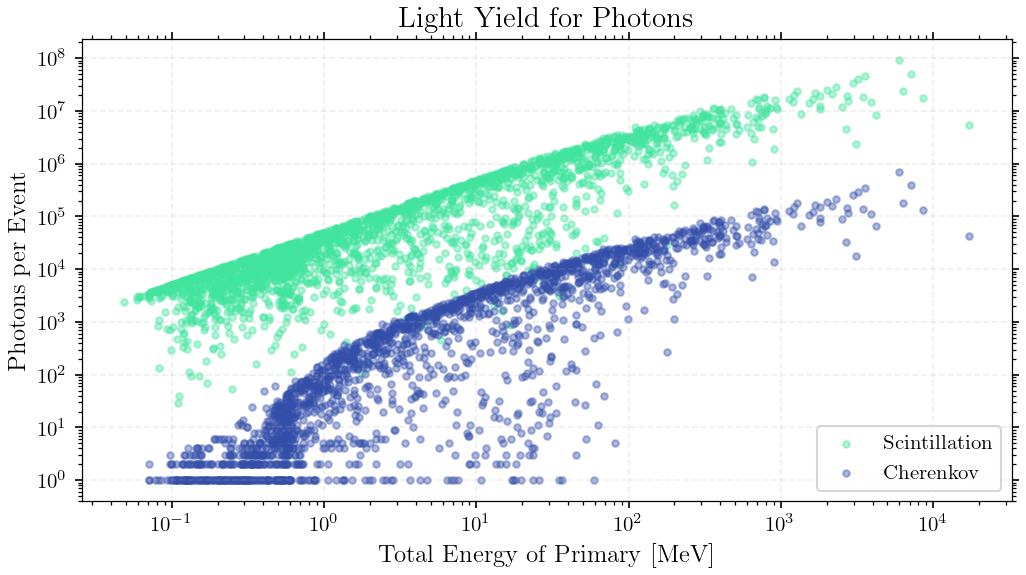

In [104]:
# single particle photon light yield plot
particle = 'photon'

data = photon_yield[particle]
primary_energies = np.array(data['energy'])
scint_photons = np.array(data['scint'])
cer_photons = np.array(data['cer'])

plt.figure(figsize=(8, 4))

# scatter for scintillation
plt.scatter(primary_energies, scint_photons, 
            alpha=0.4, s=10, label='Scintillation', color="#40E49D")
# scatter for Cherenkov
plt.scatter(primary_energies, cer_photons, 
            alpha=0.4, s=10, label='Cherenkov', color="#344FAA")

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Total Energy of Primary [MeV]")
plt.ylabel("Photons per Event")
plt.title(f"Light Yield for {particle_names[particle]}s")
plt.legend(loc='lower right')
plt.grid(True, alpha=0.2)
plt.show()

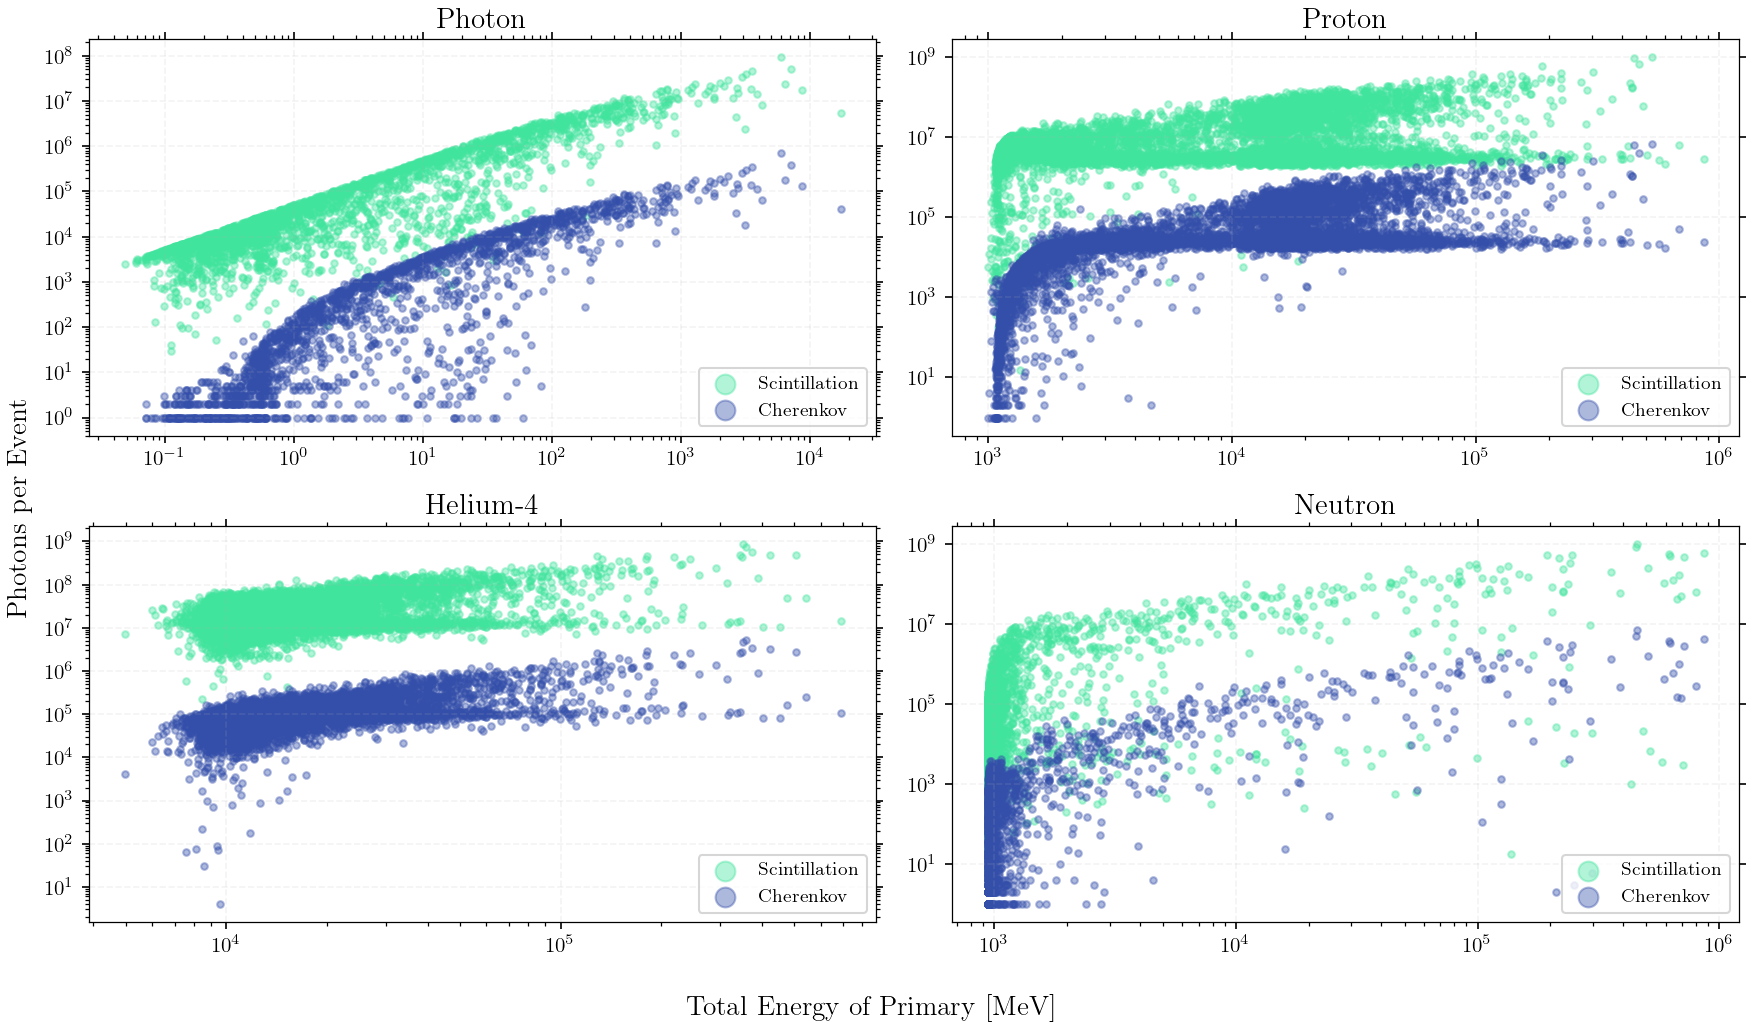

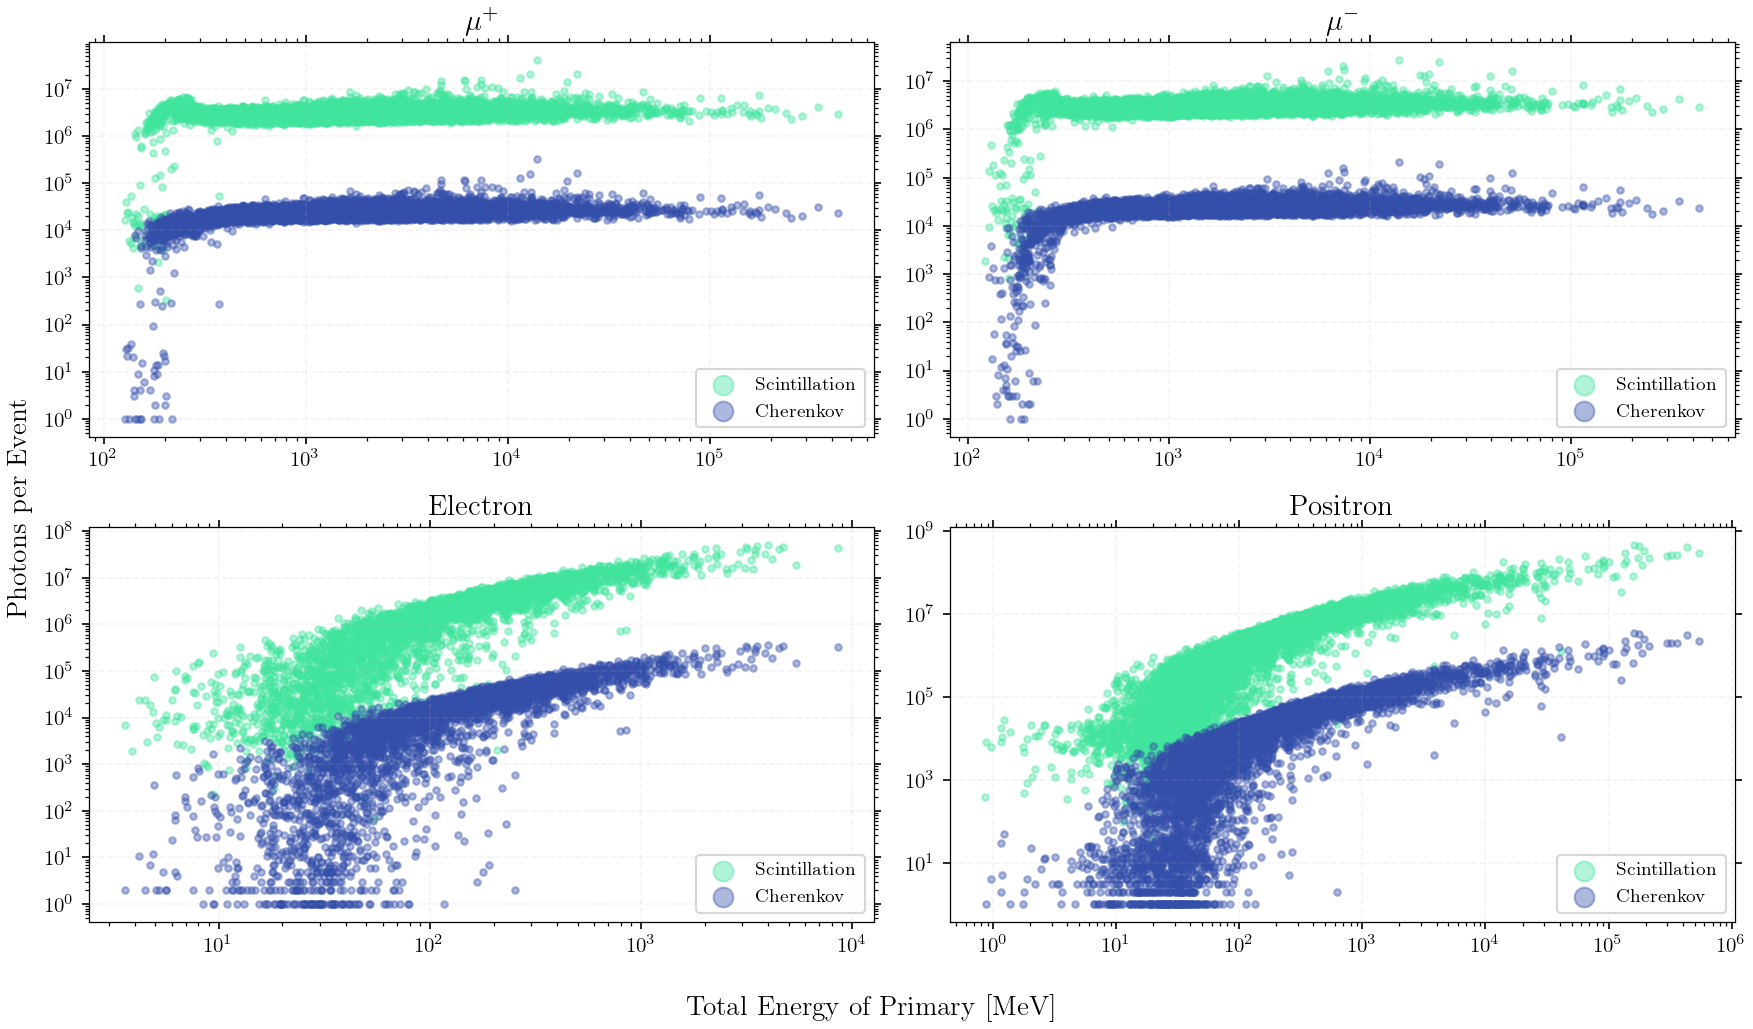

In [105]:
# grid plot for all particles
SCINT_COLOR = "#40E49D"
CER_COLOR = "#344FAA"
                      
group1 = ['photon', 'proton', 'he---4', 'neutro']
group2 = ['muplus', 'mumins', 'electr', 'positr']

def light_yield_grid(particle_list, data_source, title):
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    axes = axes.flatten()

    for ax, p in zip(axes, particle_list):
        data = data_source.get(p, {})
        
        if not data:
            ax.text(0.5, 0.5, "No Data", ha='center', transform=ax.transAxes)
            ax.set_title(particle_names.get(p, p))
            continue
            
        energies = np.array(data['energy'])
        scint = np.array(data['scint'])
        cer = np.array(data['cer'])
        
        if len(energies) == 0:
            ax.text(0.5, 0.5, "No Events", ha='center', transform=ax.transAxes)
            ax.set_title(particle_names.get(p, p))
            continue

        ax.scatter(energies, scint, alpha=0.4, s=10, 
                   label='Scintillation', color=SCINT_COLOR)
        ax.scatter(energies, cer, alpha=0.4, s=10, 
                   label='Cherenkov', color=CER_COLOR)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(particle_names.get(p, p))
        ax.grid(True, ls="--", alpha=0.15)
        ax.legend(loc='lower right', fontsize=9, markerscale=3)

    fig.supxlabel("Total Energy of Primary [MeV]")
    fig.supylabel("Photons per Event")
    fig.tight_layout()
    plt.show()

light_yield_grid(group1, photon_yield, "Photon Yield")
light_yield_grid(group2, photon_yield, "Photon Yield")

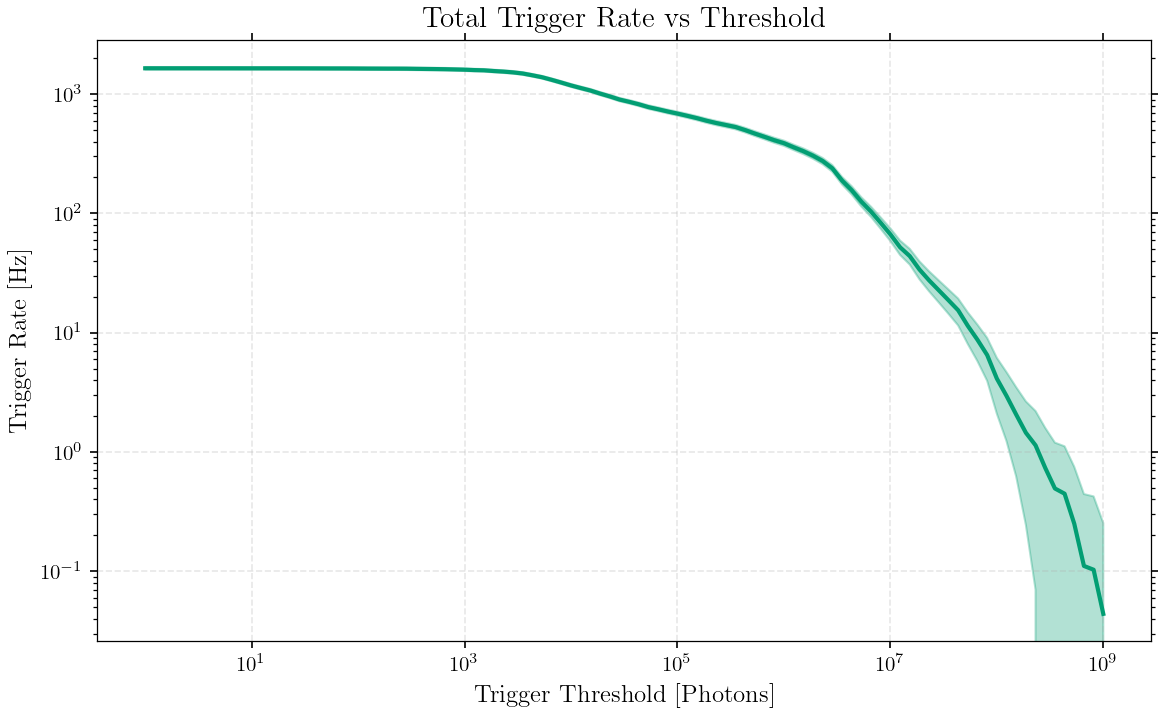

Trigger rate at threshold 1 photon:    1247.02 Hz
Trigger rate at threshold 10 photons:  1247.02 Hz
Trigger rate at threshold 100 photons: 1245.53 Hz
Trigger rate at threshold 1000 photons:1233.67 Hz


In [146]:
# calculate total trigger rates vs threshold for all particles

# first extract total photons and weights for each particle
total_photons_all = {}
weights_all = {}
for particle in PARTICLE_DICT.keys():
    data = photon_yield.get(particle, {})
    primary_energies = np.array(data.get('energy', []))
    scint_photons = np.array(data.get('scint', []))
    cer_photons = np.array(data.get('cer', []))
    total_photons = scint_photons + cer_photons
    total_photons_all[particle] = total_photons
    weights_all[particle] = weights[particle]['w']

# create threshold array (log-spaced from 1 to max photons)
total_photons_per_event = np.concatenate(list(total_photons_all.values()))
max_photons = int(np.max(total_photons_per_event))
thresholds = np.logspace(0, np.log10(max_photons), 100)  # 1 to max

# calculate trigger rate for each threshold
# trigger rate = number of events passing threshold * weight_factor
trigger_rates_all = []
errors_total = []
for T in thresholds:
    total_rate = 0.0
    total_error_sq = 0.0
    for particle in PARTICLE_DICT.keys():
        total_photons = total_photons_all[particle]
        weight = weights_all[particle]
        n_events_above_T = np.count_nonzero(total_photons >= T)
        rate = n_events_above_T * weight
        total_rate += rate
    errors = np.sqrt(total_rate)
    trigger_rates_all.append(total_rate)



# plot with error contours
plt.figure(figsize=(8, 5))
plt.plot(thresholds, trigger_rates_all, '-', color=colors[2], linewidth=2)
plt.fill_between(thresholds, 
                 np.array(trigger_rates_all) - np.sqrt(trigger_rates_all), 
                 np.array(trigger_rates_all) + np.sqrt(trigger_rates_all), 
                 color=colors[2], alpha=0.3)
plt.xlabel("Trigger Threshold [Photons]")
plt.ylabel("Trigger Rate [Hz]")
plt.title(f"Total Trigger Rate vs Threshold")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.loglog()
plt.show()


# # Print some key values
print(f"Trigger rate at threshold 1 photon:    {trigger_rates[0]:.2f} Hz")
print(f"Trigger rate at threshold 10 photons:  {trigger_rates[np.searchsorted(thresholds, 10)]:.2f} Hz")
print(f"Trigger rate at threshold 100 photons: {trigger_rates[np.searchsorted(thresholds, 100)]:.2f} Hz")
print(f"Trigger rate at threshold 1000 photons:{trigger_rates[np.searchsorted(thresholds, 1000)]:.2f} Hz")

/tmp/ipykernel_101861/3875705332.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


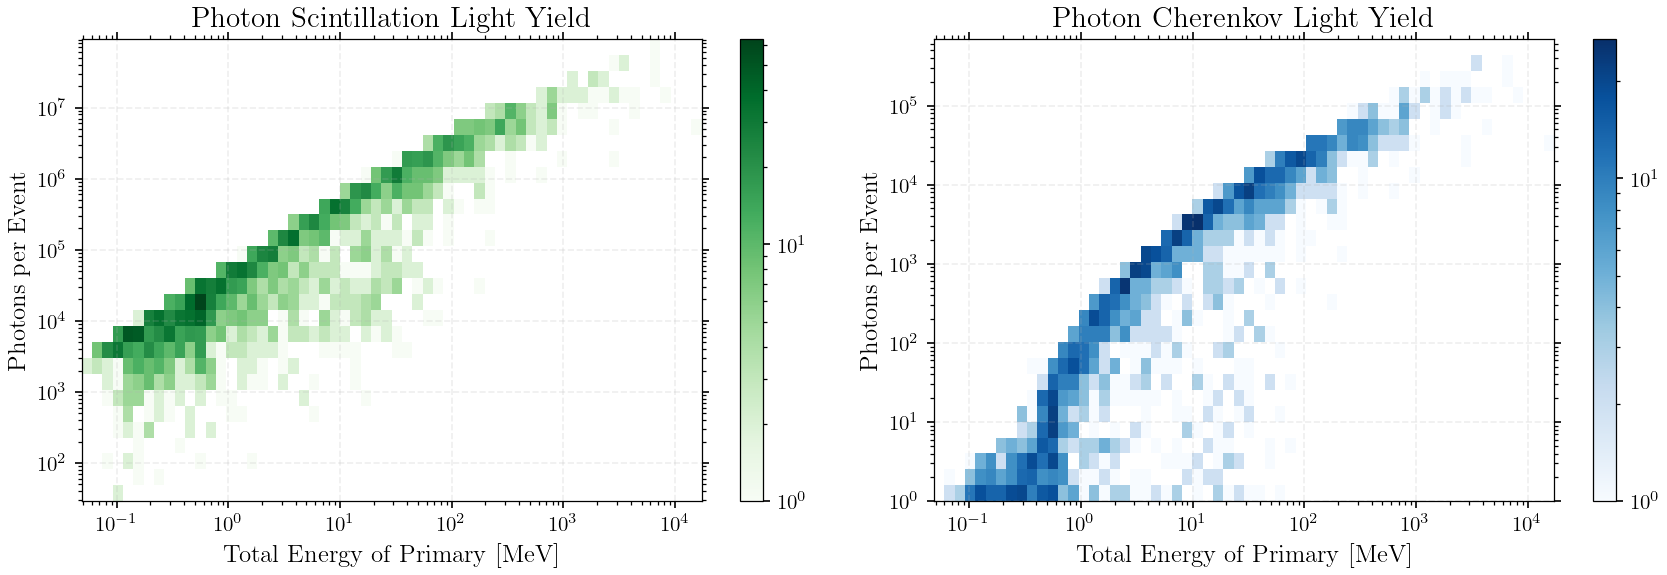

In [110]:
import matplotlib as mpl

# single particle photon light yield plot - 2D histogram version
particle = 'photon'

data = photon_yield[particle]
primary_energies = np.array(data['energy'])
scint_photons = np.array(data['scint'])
cer_photons = np.array(data['cer'])

# define log-spaced bins for both axes
energy_bins = np.logspace(np.log10(primary_energies.min()), 
                          np.log10(primary_energies.max()), 61)
photon_bins_scint = np.logspace(np.log10(scint_photons[scint_photons > 0].min()), 
                                np.log10(scint_photons.max()), 30)
photon_bins_cer = np.logspace(np.log10(cer_photons[cer_photons > 0].min()), 
                              np.log10(cer_photons.max()), 30)

fig, axes = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={'wspace': 0.1})

# 2D histogram for scintillation
h1 = axes[0].hist2d(primary_energies, scint_photons,  
                    bins=[energy_bins, photon_bins_scint],
                    cmap='Greens', norm=mpl.colors.LogNorm())
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel("Total Energy of Primary [MeV]")
axes[0].set_ylabel("Photons per Event")
axes[0].set_title(f"{particle_names[particle]} Scintillation Light Yield")
axes[0].grid(True, alpha=0.2)
plt.colorbar(h1[3], ax=axes[0])

# 2D histogram for Cherenkov
h2 = axes[1].hist2d(primary_energies, cer_photons, 
                    bins=[energy_bins, photon_bins_cer],
                    cmap='Blues', norm=mpl.colors.LogNorm())
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel("Total Energy of Primary [MeV]")
axes[1].set_ylabel("Photons per Event")
axes[1].set_title(f"{particle_names[particle]} Cherenkov Light Yield")
axes[1].grid(True, alpha=0.2)
plt.colorbar(h2[3], ax=axes[1])

plt.tight_layout()
plt.show()


[]

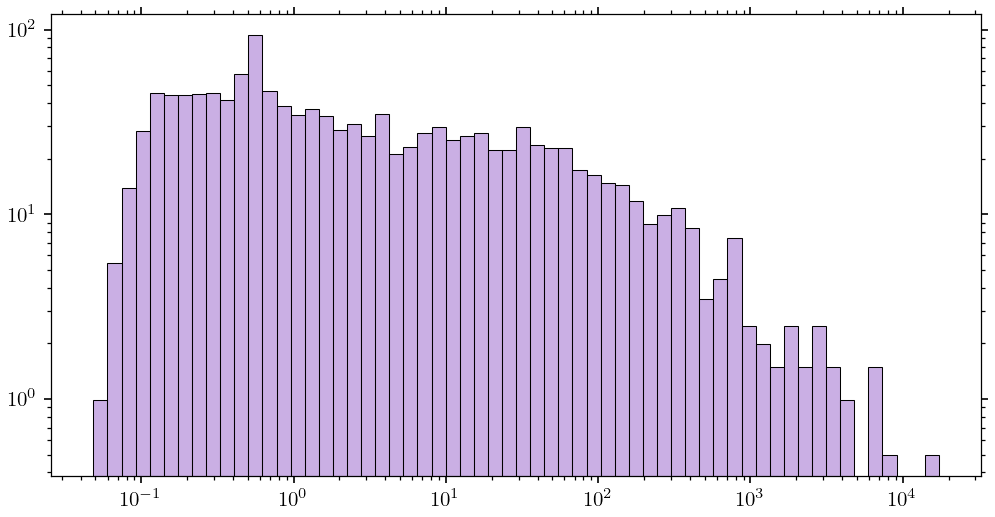

In [74]:
emin = primary_energies.min()
emax = primary_energies.max()

plt.figure(figsize=(8,4))
bins_E = np.logspace(np.log10(max(emin, 1e-12)), np.log10(emax), 61)
rates, _, _ = plt.hist(np.asarray(primary_energies), bins=bins_E, weights=np.full_like(primary_energies, weights[particle]['w']), color="#9A67CD85", edgecolor='black', lw=0.5)
plt.loglog()

In [127]:
# create an array of possible trigger thresholds (log-spaced from 1 to max photons)
total_photons_per_event = scint_photons + cer_photons
max_photons = int(np.max(total_photons_per_event))
thresholds = np.logspace(0, np.log10(max_photons), 100)  # 1 to max

trigger_rates = []
# go through each energy bin and compute fraction of events above threshold
for t in thresholds:
    fractions = []
    for i in range(len(bins_E)-1):
        bin = bins_E[i]
        mask_energies = (primary_energies > bin) & (primary_energies < bins_E[i+1])
        sliced_photons = total_photons_per_event[mask_energies]
        count_above_threshold = np.count_nonzero(sliced_photons >= t)
        total_count = len(sliced_photons)
        fraction_above = count_above_threshold / total_count if total_count > 0 else 0
        fractions.append(fraction_above)

    weighted_rates = rates * np.array(fractions)
    trigger_rate = weighted_rates.sum()
    trigger_rates.append(trigger_rate)

/tmp/ipykernel_101861/2802829509.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


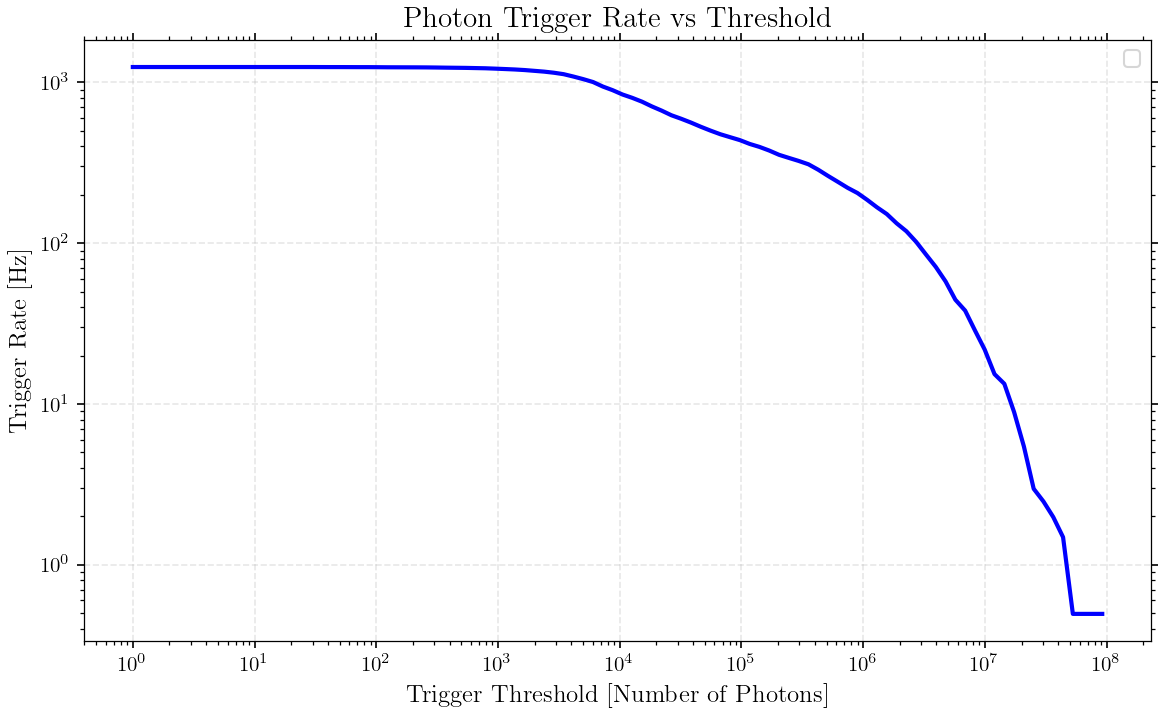

Trigger rate at threshold 1 photon:    1246.52 Hz
Trigger rate at threshold 10 photons:  1246.52 Hz
Trigger rate at threshold 100 photons: 1243.56 Hz
Trigger rate at threshold 1000 photons: 1210.93 Hz


In [128]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, trigger_rates, 'b-', linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Trigger Threshold [Number of Photons]")
plt.ylabel("Trigger Rate [Hz]")
plt.title(f"{particle_names[particle]} Trigger Rate vs Threshold")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f"Trigger rate at threshold 1 photon:    {trigger_rates[0]:.2f} Hz")
print(f"Trigger rate at threshold 10 photons:  {trigger_rates[np.searchsorted(thresholds, 10)]:.2f} Hz")
print(f"Trigger rate at threshold 100 photons: {trigger_rates[np.searchsorted(thresholds, 100)]:.2f} Hz")
print(f"Trigger rate at threshold 1000 photons: {trigger_rates[np.searchsorted(thresholds, 1000)]:.2f} Hz")

Total trigger rate for photon at threshold 10000 photons: 4.943e-01 Hz


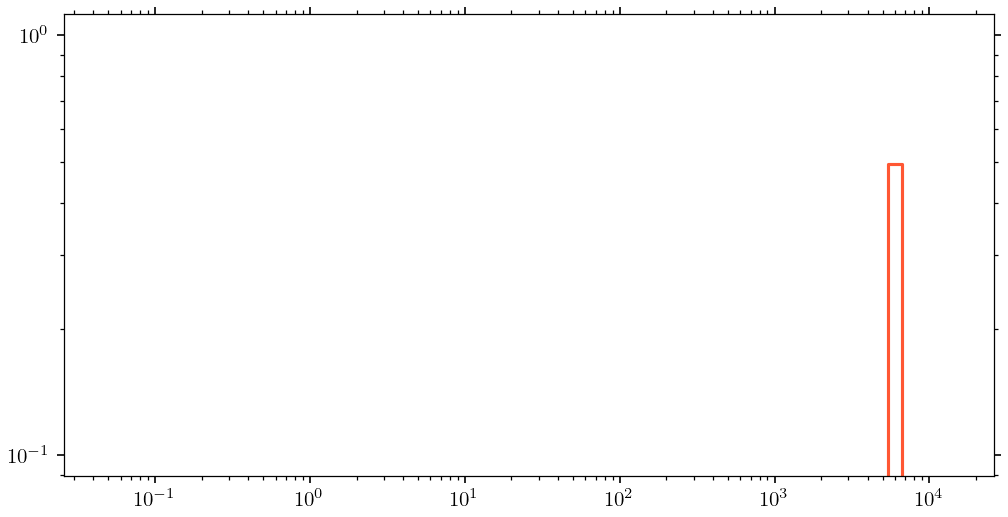

In [129]:
# plot particle rate, weighted by fraction above threshold
particle = 'photon'
weighted_rates = rates * np.array(fractions)
plt.figure(figsize=(8,4))
plt.step(bins_E[:-1], weighted_rates, where='mid', color="#FF5733")
plt.xscale('log')
plt.yscale('log')

# integrate to get total trigger rate
total_trigger_rate = np.sum(weighted_rates)
print(f"Total trigger rate for {particle} at threshold {test_threshold} photons: {total_trigger_rate:.3e} Hz")

In [130]:
# go through each energy bin

In [131]:
mask_energies = (primary_energies > 100) & (primary_energies < 200)

In [132]:
sliced_energies = primary_energies[mask_energies]
sliced_scint = scint_photons[mask_energies]
sliced_cer = cer_photons[mask_energies]

In [133]:
np.count_nonzero(sliced_scint[sliced_scint>=(401211.12081795)])

86

In [134]:
print(np.max(sliced_scint))
print(binning[-1])

5521003
5521002.999999997


In [135]:
counts_np, bins_np = np.histogram(sliced_scint, bins=binning)
print(counts_np)

[ 3 85]


[ 3. 85.]
[  29156.          401211.12081795 5521003.        ]


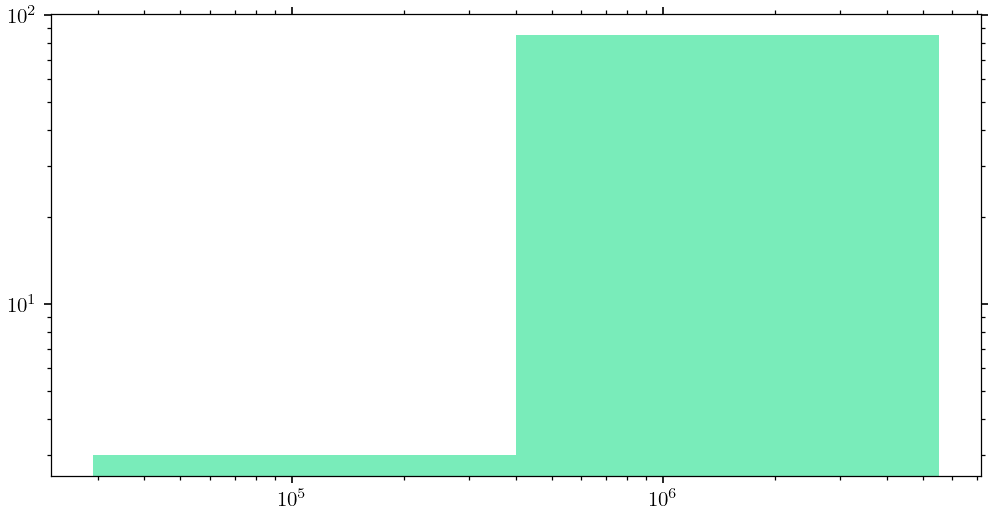

In [136]:
plt.figure(figsize=(8,4))


binning = []

binning = np.logspace(np.log10(np.min([sliced_scint])),np.log10(np.max([sliced_scint])), 3)

counts, bins, _ = plt.hist(sliced_scint, bins=binning, color=SCINT_COLOR, alpha=0.7, label='Scintillation')
# # plt.hist(sliced_cer, bins=binning, color=CER_COLOR, alpha=0.7, label='Cherenkov')
# plt.xlabel("Num Photons per Event")
# plt.legend()
# plt.ylabel("Frequency")
plt.loglog()
# # plt.hist(sliced_cer, bins=30)

print(counts)
print(bins)

/tmp/ipykernel_101861/2477138497.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


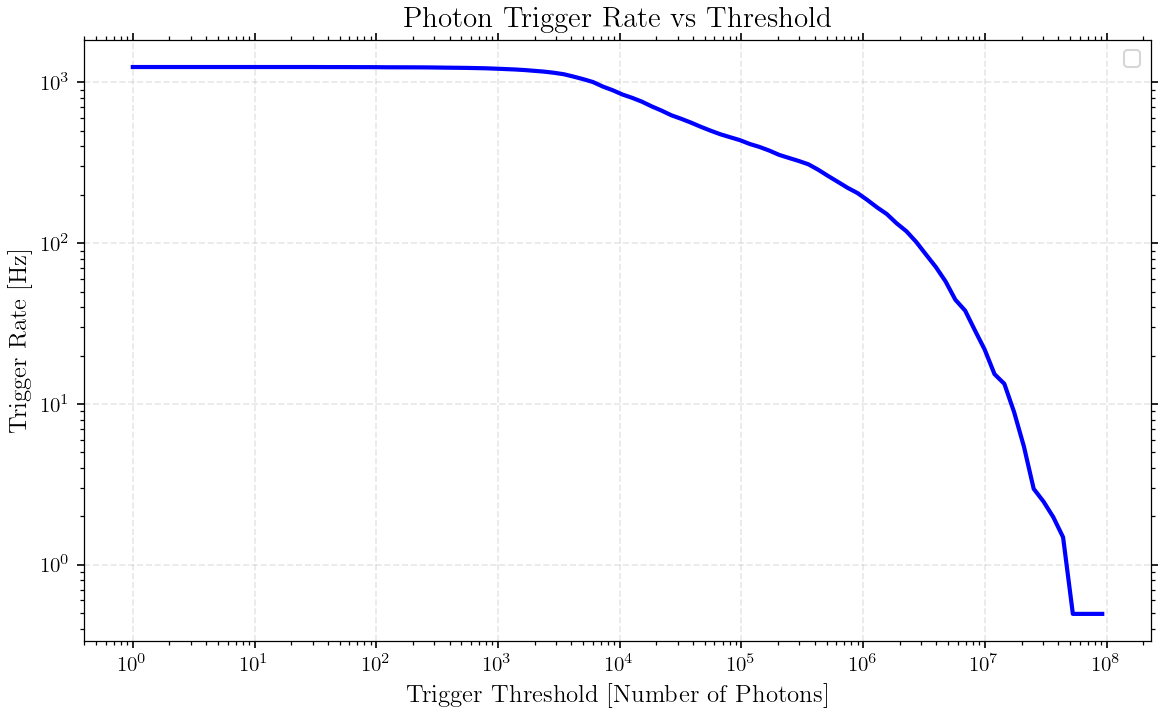

Trigger rate at threshold 1 photon:    1247.02 Hz
Trigger rate at threshold 10 photons:  1247.02 Hz
Trigger rate at threshold 100 photons: 1244.05 Hz
Trigger rate at threshold 1000 photons: 1211.43 Hz


In [138]:
# create threshold array (log-spaced from 1 to max photons)
total_photons_per_event = scint_photons + cer_photons
max_photons = int(np.max(total_photons_per_event))
thresholds = np.logspace(0, np.log10(max_photons), 100)  # 1 to max

# Calculate trigger rate for each threshold
# Trigger rate = number of events passing threshold * weight_factor
trigger_rates = []
for thresh in thresholds:
    n_passing = np.sum(total_photons_per_event >= thresh)
    rate = n_passing * weights[particle]['w']
    trigger_rates.append(rate)

trigger_rates = np.array(trigger_rates)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, trigger_rates, 'b-', linewidth=2)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Trigger Threshold [Number of Photons]")
plt.ylabel("Trigger Rate [Hz]")
plt.title(f"{particle_names[particle]} Trigger Rate vs Threshold")
plt.grid(True, alpha=0.3)

# Add some reference lines
# plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='1 Hz')
# plt.axhline(y=0.1, color='orange', linestyle='--', alpha=0.5, label='0.1 Hz')
plt.legend()

plt.tight_layout()
plt.show()

# Print some key values
print(f"Trigger rate at threshold 1 photon:    {trigger_rates[0]:.2f} Hz")
print(f"Trigger rate at threshold 10 photons:  {trigger_rates[np.searchsorted(thresholds, 10)]:.2f} Hz")
print(f"Trigger rate at threshold 100 photons: {trigger_rates[np.searchsorted(thresholds, 100)]:.2f} Hz")
print(f"Trigger rate at threshold 1000 photons: {trigger_rates[np.searchsorted(thresholds, 1000)]:.2f} Hz")

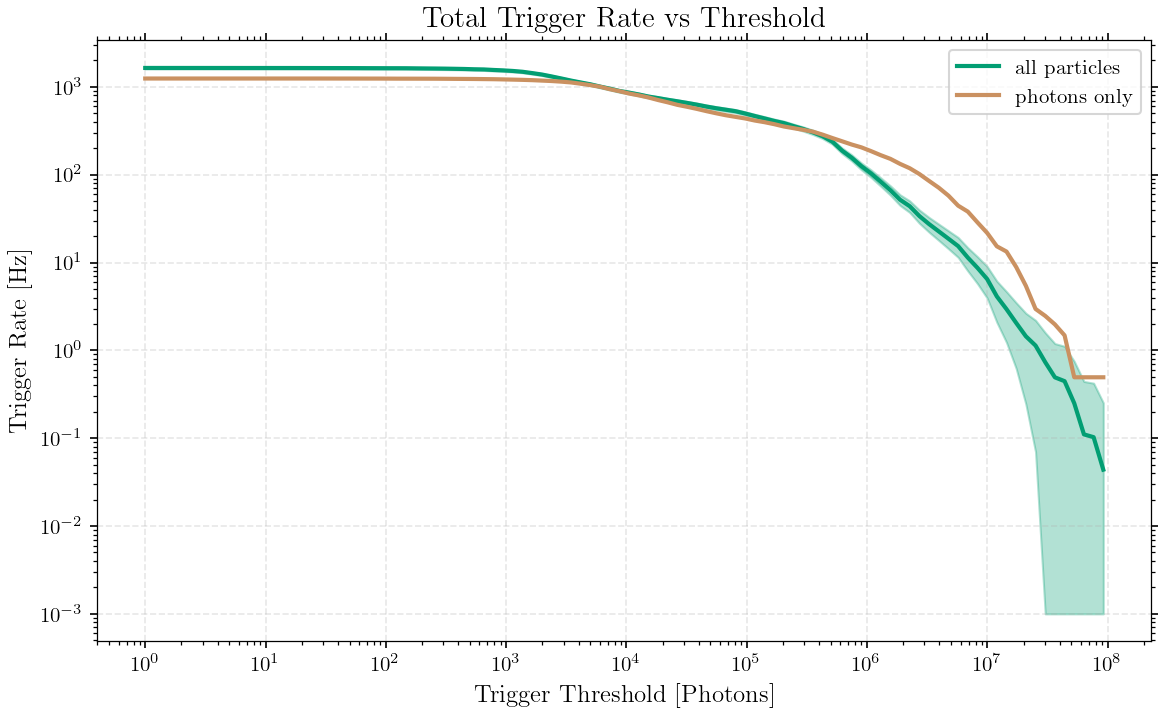

In [145]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, trigger_rates_all, '-', color=colors[2], linewidth=2, label='all particles')
plt.plot(thresholds, trigger_rates, '-', color=colors[5], linewidth=2, label='photons only')
plt.fill_between(thresholds, 
                 np.maximum(1e-3, np.array(trigger_rates_all) - np.sqrt(trigger_rates_all)), 
                 np.array(trigger_rates_all) + np.sqrt(trigger_rates_all), 
                 color=colors[2], alpha=0.3)
plt.xlabel("Trigger Threshold [Photons]")
plt.ylabel("Trigger Rate [Hz]")
plt.title(f"Total Trigger Rate vs Threshold")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.loglog()
plt.show()